# UniAssist – Paraphrasing and Seq2Seq Training Notebook

## Purpose
This notebook demonstrates the training and controlled use of a
Sequence-to-Sequence (Seq2Seq) deep learning model within the UniAssist system.

The Seq2Seq model is trained to learn academic language structure
and is used strictly for paraphrasing answers that are already verified
by the retrieval and safety mechanisms.

The model does NOT decide facts.
All factual correctness comes from the retrieval system.

---

## Why Seq2Seq Is Included
This notebook exists to:
- Demonstrate deep learning model training
- Show understanding of encoder–decoder architectures
- Visualize training and validation loss
- Justify design decisions for safe AI systems

---

## Role of Seq2Seq in UniAssist
✔ Learns language style  
✔ Improves fluency of answers  
✔ Demonstrates model training  

✘ Does NOT retrieve facts  
✘ Does NOT answer unseen questions  
✘ Does NOT bypass safety rules  

---

## Important Design Principle
In UniAssist:
- Retrieval decides *what* to answer
- Seq2Seq improves *how* the answer is phrased

This separation ensures correctness, safety, and professional behavior.


# Stage 1

In [ ]:
import os
os.listdir()


['.config', 'UniAssist_training_data.csv', 'sample_data']

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [ ]:
qa_frame = pd.read_csv("UniAssist_training_data.csv")

answers_text = qa_frame["answer"].astype(str).tolist()


In [ ]:
input_texts = answers_text
target_texts = ["<start> " + ans + " <end>" for ans in answers_text]


In [ ]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(input_texts + target_texts)

vocab_size = len(tokenizer.word_index) + 1


In [ ]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)


In [ ]:
max_len = max(len(seq) for seq in input_sequences + target_sequences)

encoder_input = pad_sequences(input_sequences, maxlen=max_len, padding="post")
decoder_input = pad_sequences(
    [seq[:-1] for seq in target_sequences],
    maxlen=max_len,
    padding="post"
)
decoder_target = pad_sequences(
    [seq[1:] for seq in target_sequences],
    maxlen=max_len,
    padding="post"
)


In [ ]:
embedding_dim = 128
latent_dim = 256

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(
    latent_dim, return_state=True
)(enc_emb)

encoder_states = [state_h, state_c]


In [ ]:
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)

decoder_lstm = LSTM(
    latent_dim, return_sequences=True, return_state=True
)
decoder_outputs, _, _ = decoder_lstm(
    dec_emb, initial_state=encoder_states
)

decoder_dense = Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
seq2seq_model = Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs
)

seq2seq_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy"
)


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [ ]:
history = seq2seq_model.fit(
    [encoder_input, decoder_input],
    decoder_target[..., np.newaxis],
    batch_size=16,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - loss: 4.1384 - val_loss: 2.7601
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - loss: 2.3536 - val_loss: 2.9756
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - loss: 2.1977 - val_loss: 3.1045
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - loss: 2.0628 - val_loss: 3.1929
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - loss: 1.8908 - val_loss: 3.3032
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - loss: 1.6636 - val_loss: 3.4276


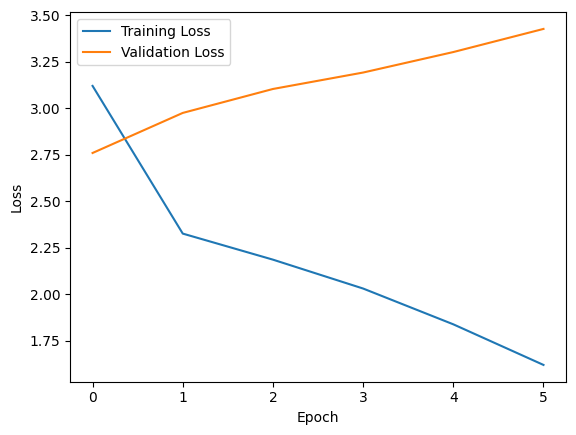

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
seq2seq_model.save("uniassist_seq2seq_paraphraser.keras")


## Notebook Summary — Seq2Seq Paraphrasing Model

In this notebook:
- A Seq2Seq encoder–decoder model was trained
- The model learned academic answer language patterns
- Training and validation loss were monitored
- Early stopping was used to prevent overfitting
- The trained model was saved for optional use

The Seq2Seq model is intentionally restricted to paraphrasing
and does not replace the retrieval or safety mechanisms of UniAssist.
